In [1]:
import os
ROOT_PATH = '/home/yasaisen/Desktop/11_research/11_research_main/lab_06'

In [2]:
# !pip install segmentation-models-pytorch
# !pip install ipywidgets

Import Libraries

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import segmentation_models_pytorch as smp

%matplotlib inline

Setup config class

In [4]:
class Config:
    
    data_dir = os.path.join(ROOT_PATH, 'fine-tune_set', 'siim-acr-pneumothorax')
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Helper Functions

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [6]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

In [7]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        rounded = np.round(pred)
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()
        
        

In [8]:
set_seed(Config.seed)

Preparing Data

In [9]:
 # non-segmap_data

images, masks = [], []

i = 0

for get_folder in os.listdir(Config.data_dir):
    if get_folder == 'png_images':
        for get_file in os.listdir(os.path.join(Config.data_dir, 'png_images')):
            if get_file in os.listdir(os.path.join(Config.data_dir, 'png_masks')):
                images += [os.path.join(Config.data_dir, 'png_images', get_file)]
                masks += [os.path.join(Config.data_dir, 'png_masks', get_file)]
                i = i+1

PathDF = pd.DataFrame({'images': images, 'masks': masks})
print(i)
PathDF.head()

12047


,images,masks
0,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
1,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
2,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
3,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
4,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...


In [10]:
# for i in PathDF.index:
#     PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [11]:
PathDF.head()

,images,masks
0,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
1,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
2,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
3,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
4,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...


In [12]:
# PathDF['diagnosis'].value_counts()

In [13]:
# ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
# ax.set_title('Data Distribution', fontsize=15)
# ax.set_ylabel('Total Images', fontsize=15)
# ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
# for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
#     ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

Train, Val, Test Split

In [14]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 9035
Valid: 1808
Test: 1204


Visualization of images and masks

In [15]:
# plot_example(0)
# plot_example(5)
# plot_example(10)
# plot_example(20)

KeyError: 'directory'

Dataset Class

In [16]:
class CXR_Dataset(Dataset):
    def __init__(self, path_df, transform):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.path_df.iloc[idx]['images']
        mask_path = self.path_df.iloc[idx]['masks']
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask#sample = (image, mask)      

Custom Transformations

In [17]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [18]:
class PairedRandomAffine():
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [19]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

In [20]:
# dataset = MRI_Dataset(test_df)
# sample = dataset[59]
# transform = PairedRandomHorizontalFlip(p=1)
# show_sample(sample, title='Original')
# show_sample(transform(sample), title="Transformed")

In [21]:
# transform = PairedRandomAffine(
#     degrees = (15,15),
#     scale_ranges = (1.2, 1.2)
# )
# show_sample(sample, "Original")
# show_sample(transform(sample), 'Transformed')

Data transformations and loaders

In [22]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()
            ])

train_data = CXR_Dataset(train_df, transform)
valid_data = CXR_Dataset(valid_df, transform)
test_data  = CXR_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=Config.test_batch , shuffle=False, num_workers=0)

Defining the Model

In [23]:
model = smp.Unet(    
    in_channels=Config.input_ch,                  
    classes=Config.output_ch,
    activation="sigmoid").to(Config.device)


Loss and metrics

In [24]:
# # code taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction:
#             return torch.mean(F_loss)
#         else:
#             return F_loss

In [25]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union


Training Loop

In [26]:
def train_loop(model, optimizer, criterion, train_loader,
              device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Evaluation Loop

In [27]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [28]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = Config.device,
          num_epochs = Config.epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/564 [00:00<?, ?it/s]/home/yasaisen/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch: 1
Train Loss: 0.02236
Train Dice Coef: 0.01424
Valid Loss: 0.01741
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


Epoch: 2
Train Loss: 0.01720
Train Dice Coef: 0.02482
Valid Loss: 0.01600
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch: 3
Train Loss: 0.01643
Train Dice Coef: 0.01418
Valid Loss: 0.02964
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch: 4
Train Loss: 0.01606
Train Dice Coef: 0.01950
Valid Loss: 0.01636
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch: 5
Train Loss: 0.01551
Train Dice Coef: 0.01064
Valid Loss: 0.01507
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


Epoch: 6
Train Loss: 0.01383
Train Dice Coef: 0.01064
Valid Loss: 0.01317
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:38<00:00,  1.47it/s]


Epoch: 7
Train Loss: 0.01322
Train Dice Coef: 0.02128
Valid Loss: 0.01287
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


Epoch: 8
Train Loss: 0.01285
Train Dice Coef: 0.01596
Valid Loss: 0.01246
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch: 9
Train Loss: 0.01248
Train Dice Coef: 0.02305
Valid Loss: 0.01291
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


Epoch: 10
Train Loss: 0.01168
Train Dice Coef: 0.02128
Valid Loss: 0.01215
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


Epoch: 11
Train Loss: 0.01143
Train Dice Coef: 0.01596
Valid Loss: 0.01206
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


Epoch: 12
Train Loss: 0.01126
Train Dice Coef: 0.01596
Valid Loss: 0.01193
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch: 13
Train Loss: 0.01097
Train Dice Coef: 0.02305
Valid Loss: 0.01193
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch: 14
Train Loss: 0.01079
Train Dice Coef: 0.02482
Valid Loss: 0.01195
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch: 15
Train Loss: 0.01076
Train Dice Coef: 0.02128
Valid Loss: 0.01199
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:38<00:00,  1.46it/s]


Epoch: 16
Train Loss: 0.01072
Train Dice Coef: 0.01064
Valid Loss: 0.01209
Valid Dice Coef: 0.00000



Interating over evaluation data: 100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


Epoch: 17
Train Loss: 0.01075
Train Dice Coef: 0.02305
Valid Loss: 0.01197
Valid Dice Coef: 0.00000



Iterating over train data:  32%|███▏      | 182/564 [01:21<02:51,  2.23it/s]


KeyboardInterrupt: 

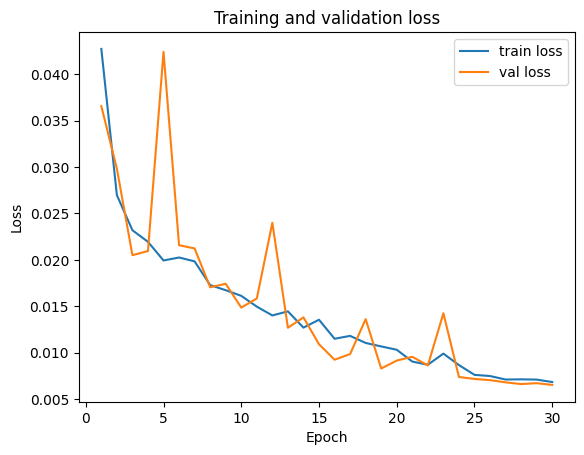

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, Config.epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

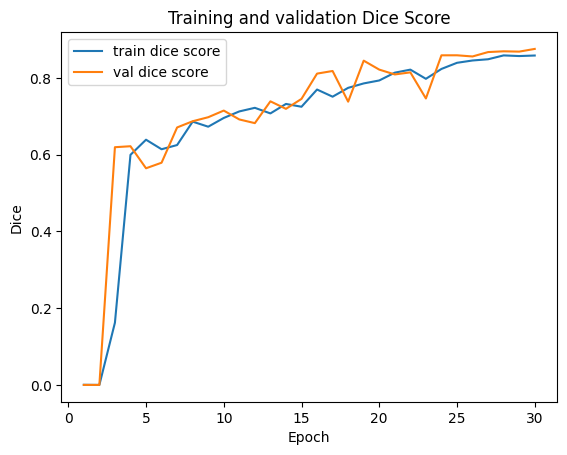

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, Config.epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

/tmp/ipykernel_182046/3255609807.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)


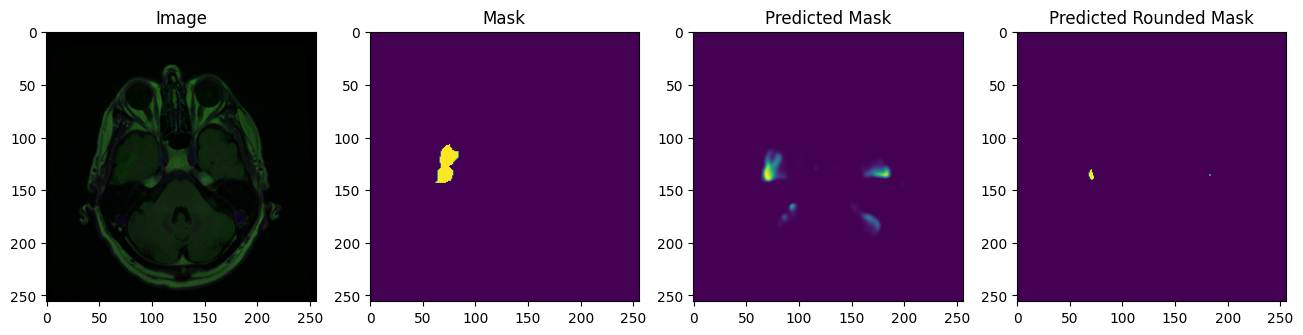

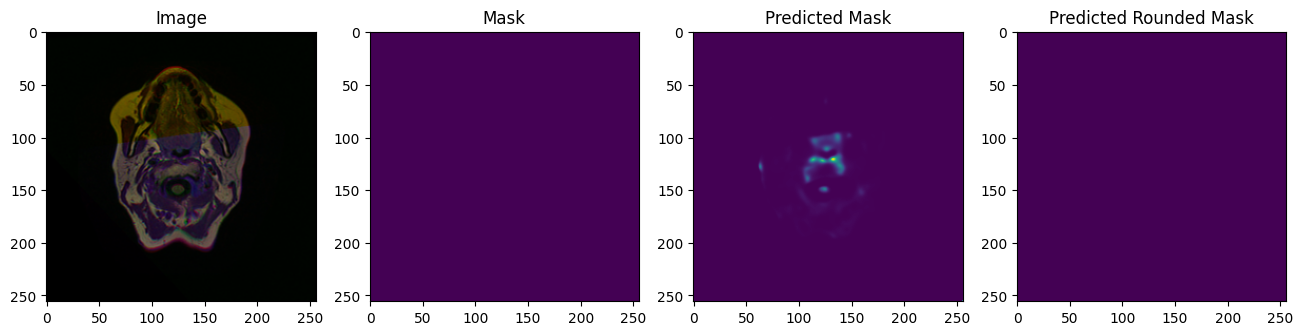

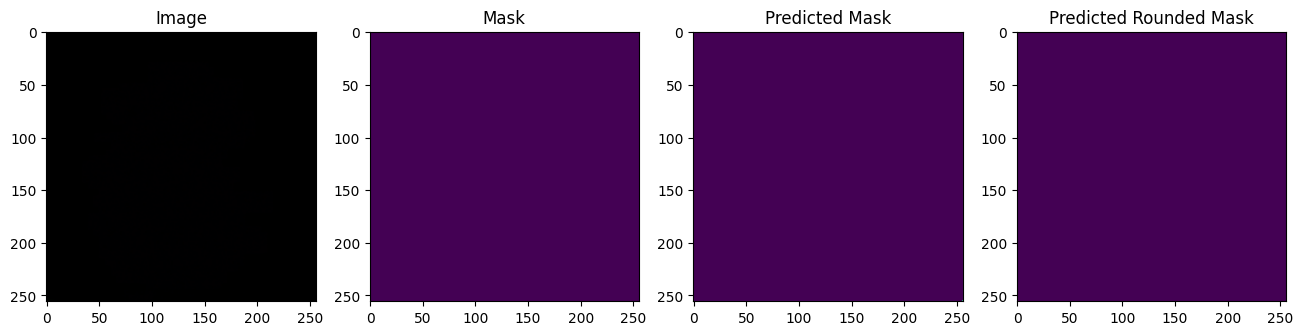

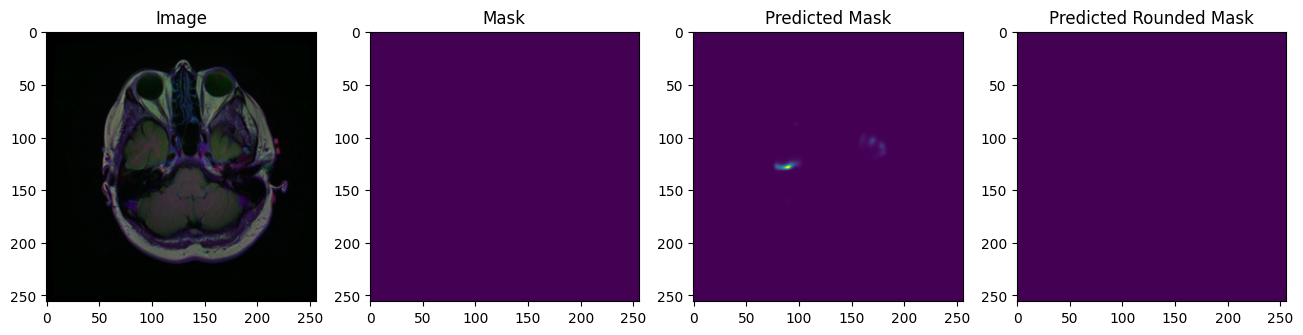

In [ ]:
plot_predictions(model, 59)
plot_predictions(model, 0)
plot_predictions(model, 26)
plot_predictions(model, 3)

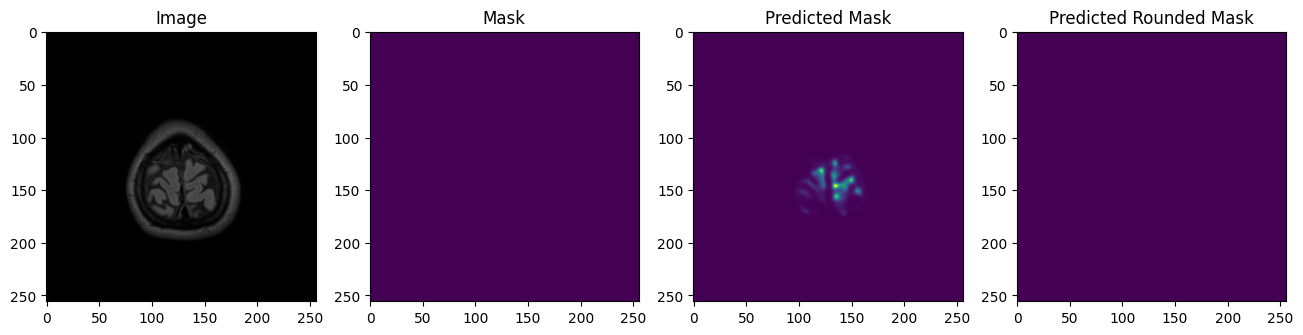

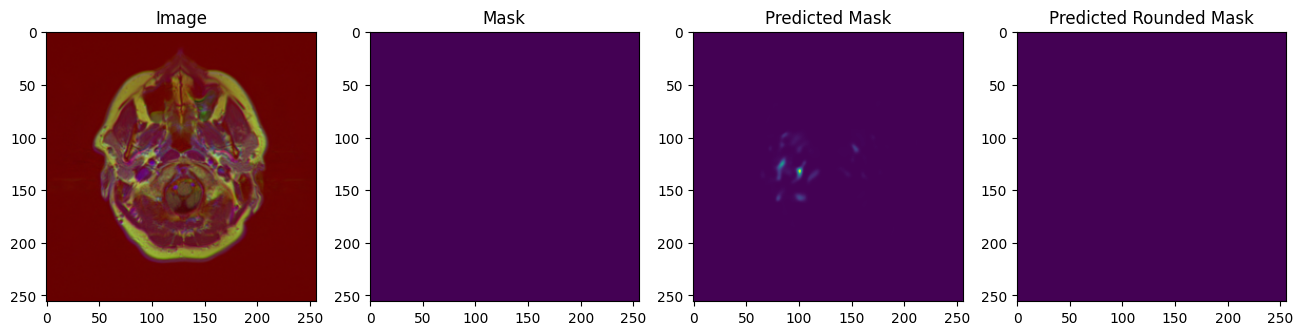

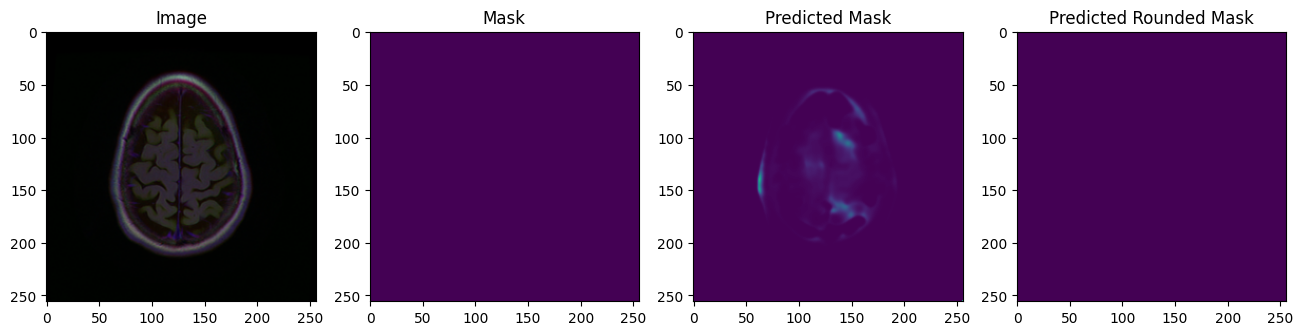

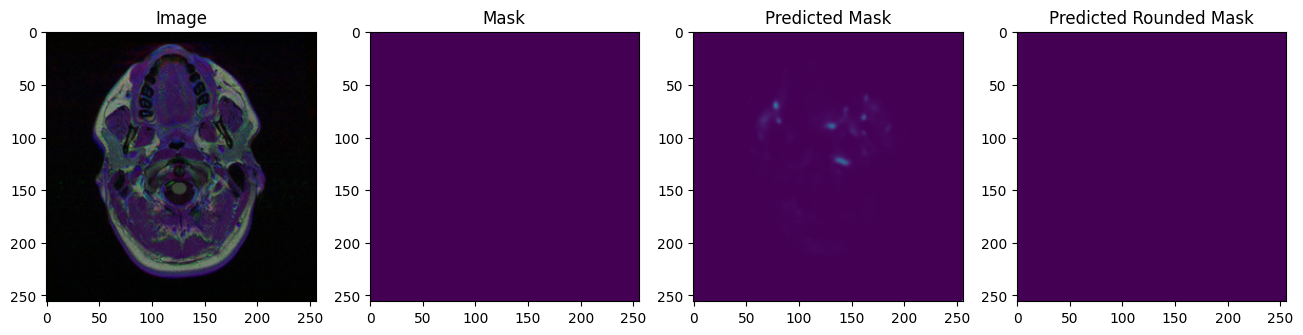

In [ ]:
plot_predictions(model, 7)
plot_predictions(model, 31)
plot_predictions(model, 28)
plot_predictions(model, 1)

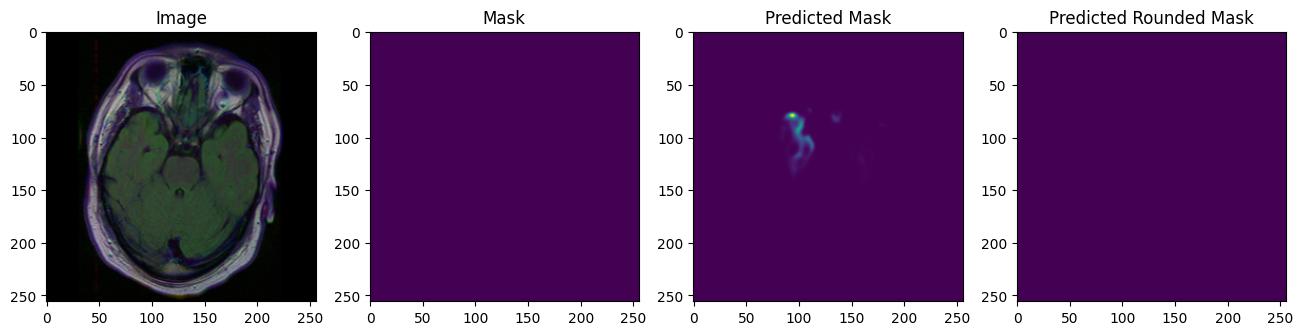

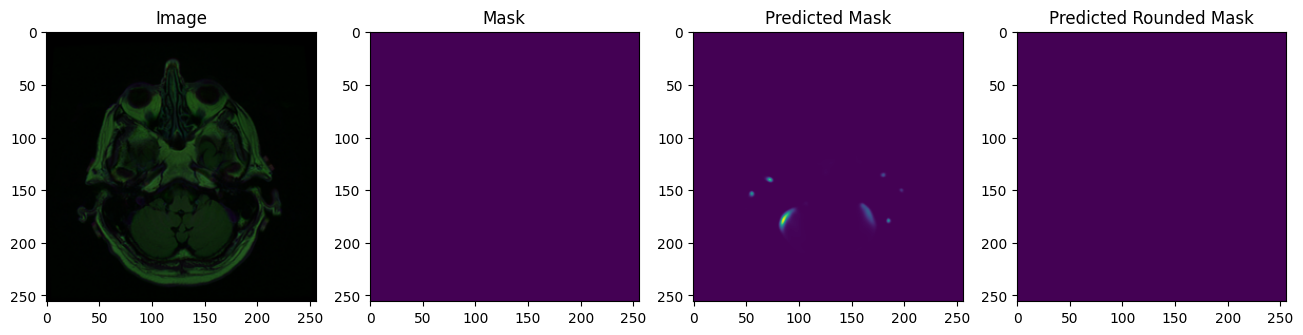

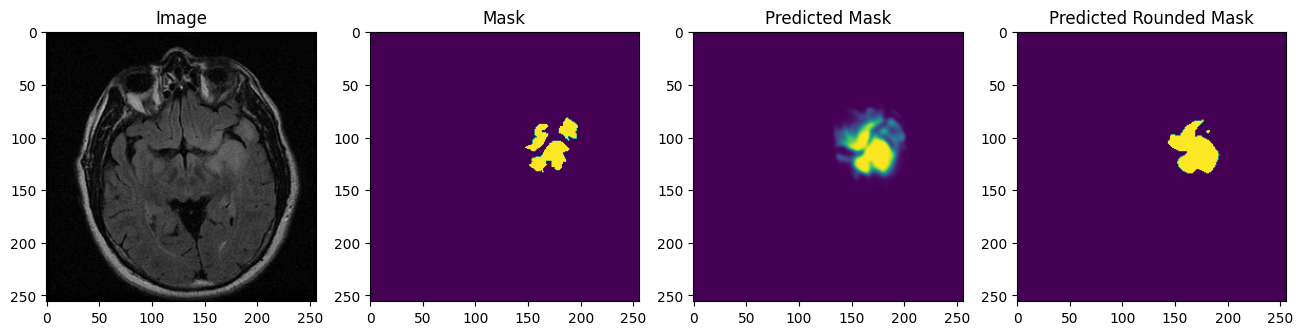

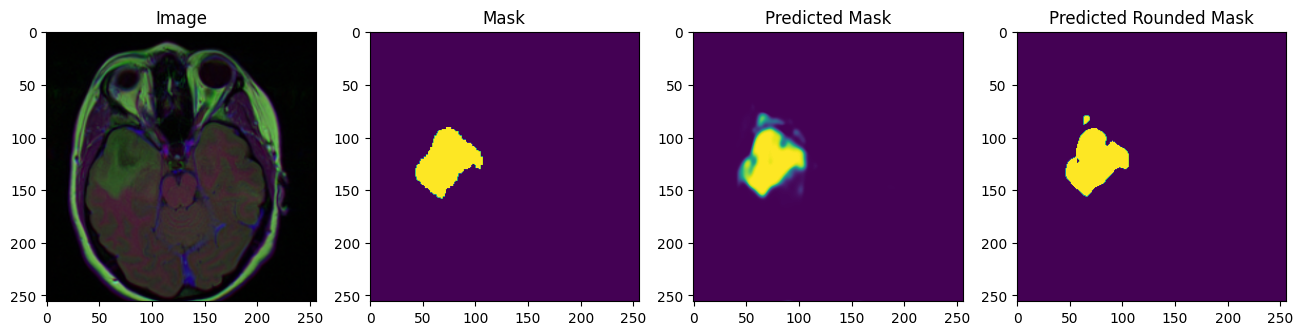

In [ ]:
plot_predictions(model, 15)
plot_predictions(model, 19)
plot_predictions(model, 25)
plot_predictions(model, 73)

Heavily Inspired from https://www.kaggle.com/code/anastasiiaselezen/brain-mri-segmentation-pytorch